In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('combined_traj_data.csv')

In [3]:
# Feature engineering
df['speed'] = np.sqrt(df['vx']**2 + df['vy']**2)
df['heading'] = np.arctan2(df['vy'], df['vx'])
df['accel'] = df['speed'].diff() / df['t'].diff()
df['turn_rate'] = df['heading'].diff() / df['t'].diff()
df['distance'] = np.sqrt(df['x'].diff()**2 + df['y'].diff()**2)

features = df[['speed', 'heading', 'accel', 'turn_rate', 'distance']]

In [ ]:
features['accel'].fillna(0, inplace=True)
features['turn_rate'].fillna(0, inplace=True)
features['distance'].fillna(0, inplace=True)

In [5]:
features.head()

,speed,heading,accel,turn_rate,distance
0,14.1,1.186824,0.000000,0.000000e+00,0.000000
1,14.0,1.186824,-0.001587,-2.819614e-17,0.004410
2,14.1,1.186824,0.004545,8.074349e-17,0.001710
3,14.0,1.186824,-0.003448,-6.125368e-17,0.001645
4,14.0,1.186824,0.000000,0.000000e+00,0.005133


In [6]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor()
y_pr = lof.fit_predict(features)

In [7]:
inlier_indices = y_pr == 1
features_no_outliers = features[inlier_indices]

In [8]:
features_no_outliers = features_no_outliers.reset_index(drop=True)

In [9]:
features_no_outliers.head()

,speed,heading,accel,turn_rate,distance
0,14.1,1.186824,0.004545,8.074349e-17,0.001710
1,14.1,1.186824,0.000327,5.805088e-18,0.021769
2,14.1,1.186824,0.000000,0.000000e+00,0.000922
3,14.1,1.186824,0.000000,0.000000e+00,0.000428
4,14.1,1.186824,0.000000,0.000000e+00,0.001717


In [ ]:
# Cluster trajectories
kmeans = KMeans(n_clusters=5)
features_no_outliers['cluster'] = kmeans.fit_predict(features_no_outliers)

# Identify normal cluster
cluster_list = features_no_outliers['cluster'].tolist()
normal_cluster = max(set(cluster_list), key=cluster_list.count)

In [11]:
features_no_outliers['cluster'] = np.where(features_no_outliers['cluster'] == normal_cluster, 1, 0)

In [12]:
features_no_outliers.head()

,speed,heading,accel,turn_rate,distance,cluster
0,14.1,1.186824,0.004545,8.074349e-17,0.001710,0
1,14.1,1.186824,0.000327,5.805088e-18,0.021769,0
2,14.1,1.186824,0.000000,0.000000e+00,0.000922,0
3,14.1,1.186824,0.000000,0.000000e+00,0.000428,0
4,14.1,1.186824,0.000000,0.000000e+00,0.001717,0


In [13]:
normal_features = features_no_outliers[['speed', 'heading', 'accel', 'turn_rate', 'distance']]

In [14]:
X = normal_features.values
y = features_no_outliers['cluster'].values

In [15]:
from sklearn.preprocessing import LabelEncoder
y_labelencoder = LabelEncoder()
Y = y_labelencoder.fit_transform(y)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [17]:
import tensorflow as tf
# Perform one-hot encoding on the labels
NUM_CLASSES = len(np.unique(Y_train))
y_train = tf.one_hot(Y_train, NUM_CLASSES)
y_test = tf.one_hot(Y_test, NUM_CLASSES)

In [18]:
batch_size = 32

# Reshape the input data to match the expected shape for Conv1D
x_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
x_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [19]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Create the Sequential model
model = Sequential()

# First Conv1D layer with 32 filters, kernel size of 3, and 'relu' activation
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))

# BatchNormalization
model.add(BatchNormalization())

# MaxPooling
model.add(MaxPooling1D(pool_size=1))

# Dropout
model.add(Dropout(0.25))

# Second Conv1D layer with 64 filters and a kernel size of 3
model.add(Conv1D(64, kernel_size=3, activation='relu'))

# BatchNormalization
model.add(BatchNormalization())

# MaxPooling
model.add(MaxPooling1D(pool_size=1))

# Dropout
model.add(Dropout(0.25))

# Flatten layer to convert the output to a 1D vector
model.add(Flatten())

# Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

# Output layer with appropriate activation (e.g., sigmoid for binary classification)
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Print the model summary to check the shapes
model.summary()

epochs = 5

# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 32)             128       
                                                                 
 batch_normalization (BatchN  (None, 3, 32)            128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 32)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 3, 32)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             6208      
                                                                 
 batch_normalization_1 (Batc  (None, 1, 64)            2

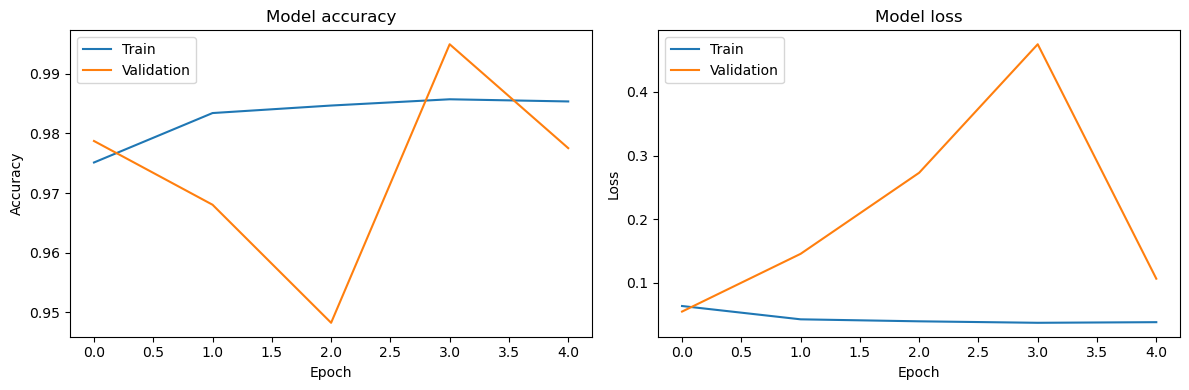

In [20]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [21]:
import numpy as np

# Generate 15 normal trajectories
num_traj = 15
traj_len = 50
normal_trajectories = []
for i in range(num_traj):
    x = np.random.uniform(low=-5.0, high=5.0, size=traj_len)
    y = np.random.uniform(low=40.0, high=60.0, size=traj_len)
    vx = np.random.normal(loc=10, scale=2, size=traj_len)
    vy = np.random.normal(loc=10, scale=2, size=traj_len)
    t = np.arange(traj_len)
    traj_num = np.full(traj_len, i+1)
    trajectory = np.column_stack((x, y, vx, vy, t, traj_num)) 
    normal_trajectories.append(trajectory)

# Generate location-based anomalies
num_loc_anom = 7
loc_anom_traj = []
for i in range(num_loc_anom):
    t = np.random.randint(10, 40)
    x = np.random.uniform(low=10, high=15)
    y = np.random.uniform(low=10, high=15)
    anomaly_traj = normal_trajectories[i].copy()
    anomaly_traj[t,0] = x
    anomaly_traj[t,1] = y
    loc_anom_traj.append(anomaly_traj)

# Generate velocity-based anomalies
num_vel_anom = 8
vel_anom_traj = []
for i in range(num_vel_anom):
    t = np.random.randint(10, 40)
    vx = np.random.normal(loc=40, scale=5)
    vy = np.random.normal(loc=40, scale=5)
    anomaly_traj = normal_trajectories[i+num_loc_anom].copy()
    anomaly_traj[t,2] = vx
    anomaly_traj[t,3] = vy
    vel_anom_traj.append(anomaly_traj)

abnormal_trajectories = loc_anom_traj + vel_anom_traj

In [22]:
import pandas as pd

# List of column names
cols = ['x', 'y', 'vx', 'vy', 't', 'traj_number']

# Create empty dataframe
df = pd.DataFrame(columns=cols)

# Loop through trajectories and append to dataframe
for traj in abnormal_trajectories:
    df_temp = pd.DataFrame(traj, columns=cols)
    df = pd.concat([df, df_temp])


In [23]:
df.reset_index(drop=True)

,x,y,vx,vy,t,traj_number
0,-2.655495,55.299449,8.920412,11.759586,0.0,1.0
1,1.638487,46.695453,10.394731,10.124138,1.0,1.0
2,2.359657,50.045095,12.501435,5.013981,2.0,1.0
3,3.759873,58.721794,4.890865,11.896165,3.0,1.0
4,3.089844,45.001238,9.768309,5.857590,4.0,1.0
...,...,...,...,...,...,...
745,-3.827364,57.653486,9.649457,14.931643,45.0,15.0
746,1.314847,44.630274,8.997663,8.885026,46.0,15.0
747,0.420715,48.094687,10.944261,10.967625,47.0,15.0
748,3.531299,54.826600,6.463004,8.704154,48.0,15.0


In [24]:
# Feature engineering
df['speed'] = np.sqrt(df['vx']**2 + df['vy']**2)
df['heading'] = np.arctan2(df['vy'], df['vx'])
df['accel'] = df['speed'].diff() / df['t'].diff()
df['turn_rate'] = df['heading'].diff() / df['t'].diff()
df['distance'] = np.sqrt(df['x'].diff()**2 + df['y'].diff()**2)

In [30]:
features = df[['speed', 'heading', 'accel', 'turn_rate', 'distance']]

In [ ]:
features['accel'].fillna(0, inplace=True)
features['turn_rate'].fillna(0, inplace=True)
features['distance'].fillna(0, inplace=True)

In [32]:
features.head()

,speed,heading,accel,turn_rate,distance
0,14.760136,0.921836,0.000000,0.000000,0.000000
1,14.510293,0.772211,-0.249843,-0.149625,9.615977
2,13.469443,0.381431,-1.040850,-0.390781,3.426396
3,12.862321,1.180732,-0.607122,0.799302,8.788953
4,11.389961,0.540164,-1.472360,-0.640569,13.736906


In [ ]:
features['cluster'] = kmeans.predict(features)

In [ ]:
features['cluster'] = np.where(features['cluster'] == normal_cluster, 1, 0)

In [35]:
X_val =  features[['speed', 'heading', 'accel', 'turn_rate', 'distance']]

In [36]:
x_val = X_val.values
y_val = features['cluster'].values

In [37]:
y_validation = y_labelencoder.fit_transform(y_val)

In [38]:
NUM_CLASSES = len(np.unique(y_validation))
y_valid = tf.one_hot(y_validation, NUM_CLASSES)

In [40]:
x_valid = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

In [43]:
from sklearn.metrics import accuracy_score
import numpy as np
y_pred = model.predict(x_valid)

# Assuming y_pred contains probability scores for each class, you can convert them to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_valid, axis=1)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_true_classes, y_pred_classes)

print(f'Accuracy on new data: {accuracy * 100:.2f}%')

24/24 [==============================] - 0s 2ms/step
Accuracy on new data: 84.80%
